#### Bibliotecas utilizadas

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

#### I Projeções

#### Coordenadas do cubo no espaço e no plano da câmera

In [22]:
cube_vertices_3d = np.array([[ 2,  2,  2],
                             [-2,  2,  2],
                             [-2,  2, -2],
                             [ 2,  2, -2],
                             [ 2, -2,  2],
                             [-2, -2,  2],
                             [-2, -2, -2],
                             [ 2, -2, -2]])

cube_vertices_image = np.array([[422, 323],
                                [178, 323],
                                [118, 483],
                                [482, 483],
                                [438, 73],
                                [162, 73],
                                [78, 117],
                                [522, 117]])
print(cube_vertices_3d)
print(cube_vertices_image)

[[ 2  2  2]
 [-2  2  2]
 [-2  2 -2]
 [ 2  2 -2]
 [ 2 -2  2]
 [-2 -2  2]
 [-2 -2 -2]
 [ 2 -2 -2]]
[[422 323]
 [178 323]
 [118 483]
 [482 483]
 [438  73]
 [162  73]
 [ 78 117]
 [522 117]]


#### Funções para normalizar os pontos

In [8]:
def normalize_points_3d(points):
    centroid       = np.array([np.mean(points[:,0]), np.mean(points[:,1]), np.mean(points[:,2])])
    shifted_points = np.transpose(np.array( [points[:,0]-centroid[0], points[:,1]-centroid[1], points[:,2]-centroid[2]]))

    avg_dist   = 0;
    number_pts = points.shape[0]
    for i in range(number_pts):
        avg_dist += np.sqrt((shifted_points[i,0] ** 2 + shifted_points[i,1] ** 2 + shifted_points[i,2] ** 2))
    avg_dist /= number_pts
    
    scale = np.sqrt(3) / avg_dist

    T = np.array([[scale,   0,     0, -scale * centroid[0]], 
                  [ 0,  scale,     0, -scale * centroid[1]], 
                  [ 0,      0, scale, -scale * centroid[2]],
                  [ 0,      0,     0,          1]] ) 

    n = points.shape[0]
    homogeneous_points = np.hstack((points, np.ones((n, 1))))
    normalized_points_homogeneous = (T @ homogeneous_points.T).T
    normalized_points = normalized_points_homogeneous[:, :3]

    return normalized_points, T

def normalize_points(points):
    centroid       = np.array([np.mean(points[:,0]), np.mean(points[:,1])])
    shifted_points = np.transpose(np.array( [points[:,0]-centroid[0], points[:,1]-centroid[1]]))

    avg_dist   = 0;
    number_pts = points.shape[0]
    for i in range(number_pts):
        avg_dist += np.sqrt(shifted_points[i,0] ** 2 + shifted_points[i,1] ** 2)
    avg_dist /= number_pts
    
    scale = np.sqrt(2) / avg_dist

    T = np.array([[scale,   0, -scale * centroid[0]], 
                  [ 0,  scale, -scale * centroid[1]], 
                  [ 0,      0,         1]] )

    n = points.shape[0]
    homogeneous_points = np.hstack((points, np.ones((n, 1))))
    normalized_points_homogeneous = (T @ homogeneous_points.T).T
    normalized_points = normalized_points_homogeneous[:, :2]

    return normalized_points, T

#### 1 - Plot das arestas do cubo projetadas no plano da câmera

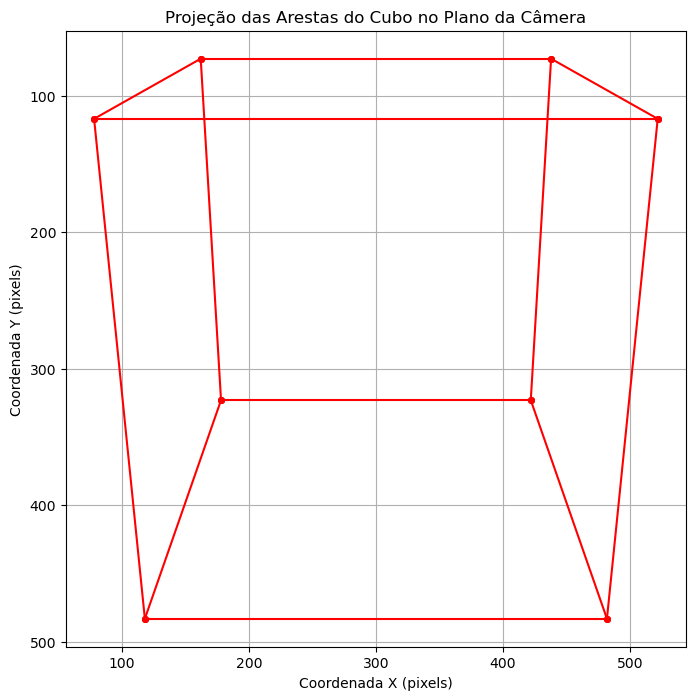

In [11]:
edges = [(0, 1), (1, 2), (2, 3), (3, 0),  
         (4, 5), (5, 6), (6, 7), (7, 4),  
         (0, 4), (1, 5), (2, 6), (3, 7)]  

plt.figure(figsize=(8, 8))
for edge in edges:
    start, end = edge
    plt.plot( [cube_vertices_image[start, 0], cube_vertices_image[end, 0]],
              [cube_vertices_image[start, 1], cube_vertices_image[end, 1]],
               'ro-', markersize=4)

plt.gca().invert_yaxis()
plt.title("Projeção das Arestas do Cubo no Plano da Câmera")
plt.xlabel("Coordenada X (pixels)")
plt.ylabel("Coordenada Y (pixels)")
plt.grid()
plt.show()

#### 2 - Cálculo da matriz de projeção P da câmera

In [14]:
# Algoritmo DLT normalizado para calcular a matriz P da câmera

n = cube_vertices_3d.shape[0]
A = np.zeros((2 * n, 12)) 

cube_image_norm, T_img = normalize_points(cube_vertices_image);
cube_3d_norm, T_cube   = normalize_points_3d(cube_vertices_3d);

for i in range(n):
    X, Y, Z      = cube_3d_norm[i]
    x, y         = cube_image_norm[i]
    A[2 * i]     = [X, Y, Z, 1, 0, 0, 0, 0, -x * X, -x * Y, -x * Z, -x]
    A[2 * i + 1] = [0, 0, 0, 0, X, Y, Z, 1, -y * X, -y * Y, -y * Z, -y]

A = np.array(A)
U, S, Vt = linalg.svd(A)
P  = Vt[-1].reshape(3, 4)
P  = np.linalg.inv(T_img) @ P @ T_cube

# Matriz P
print("P:",P)

P: [[4.60427137e+01 6.76229152e+00 1.88024492e+01 1.75715226e+02]
 [1.07130557e-17 4.88954065e+01 1.65384701e-02 1.46393425e+02]
 [4.62989645e-17 2.25409717e-02 6.26748307e-02 5.85717421e-01]]


#### 3 - Cálculo dos parâmetros intrínsecos (K) e extrínsecos (R; t) da câmera.

In [17]:
# Decompondo P
M = P[:, :3]
t = P[:, 3]

# Fatoração RQ 
K, R = linalg.rq(np.linalg.inv(M))  

T = np.diag(np.sign(np.diag(K)))  # Matriz diagonal com os sinais dos elementos da diagonal de K
K = K @ T                         # Correção dos sinais da diagonal de K
R = T @ R                         # Compensação da correção dos sinais da diagonal de K
K /= K[2, 2]                      # Normalização do último elemento de K

# Centro óptico da câmera em relação ao centro do cubo
C_til = -linalg.inv(M) @ t

# Distâncias focais 
f1 = K[0, 0] 
f2 = K[1, 1]

#### Resultados

In [20]:
print("K:",K)
print("")
print("R:",R)
print("")
print("t:",t)
print("")
print("C_til:",C_til)
print("")
print("Distâncias focais:",f1,f2)

K: [[ 1.36106660e-03 -1.88237072e-04 -4.08319936e-01]
 [ 0.00000000e+00  1.28165809e-03 -3.38832645e-04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

R: [[ 1.00000000e+00  2.32676461e-19  1.00556550e-18]
 [-2.33140006e-19  9.99999894e-01  4.61003824e-04]
 [-1.00545813e-18 -4.61003824e-04  9.99999894e-01]]

t: [175.71522645 146.39342494   0.58571742]

C_til: [-2.22044605e-15 -2.99121471e+00 -8.26954823e+00]

Distâncias focais: 0.0013610665972669848 0.0012816580855488293


#### A posição do centro ótico da câmera do robô em relação ao centro do cubo é:
$$ \tilde{C} = 
\begin{bmatrix}
-2.22044605 \times 10^{-15} \\
-2.99121471 \\
-8.26954823
\end{bmatrix}$$

#### Levando em consideração as flutuações numéricas dado a precisão na representação dos valores e fazendo as devidas aproximações, a distância focal da câmera é:

$$ f \approx 0.0013$$